In [1]:
import pandas as pd
import scipy as sp
from scipy.sparse import diags
import numpy as np
from numpy import linalg as LA
import sys

import matplotlib.pyplot as plt

#importing seaborn for plotting
import seaborn as sns

#for plotting purposes
%pylab inline
sns.set_style('ticks')
sns.set_context('paper')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib as mpl

# mpl.rcParams
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['figure.figsize'] = [8, 16/3]

Populating the interactive namespace from numpy and matplotlib


### Trying out background subtraction

In [63]:
#porting from HITRACE

#based on Baseline correction for NMR spectroscopic metabolomics data analysis. 2008, 
#Author(s): Xi, Yuanxin and Rocke, David M
#https://doi.org/10.1186/1471-2105-9-324 and further modified by Rhiju (Stanford University)
#name of variables tracks closely to what is presented in the manuscript

def baseline_xi(b,A=2e9,B=2e4,s=1.0):

    # Input: 
    # b Nx1, spectrum data
    # A 1x1 smoothing factor
    # B 1x1 negative penalty
    # s 1x1 noise standard deviation

    # Output:
    # bd Nx1 baseline

    L = len(b)

    # b is the SIGNAL (gamma in the paper). bd is the estimated baseline (b in the paper).
    bd = np.ones((L,1))*np.median(b)
    bd0 = b

    #current error
    nm = LA.norm(b-bd0)
    nm0 = sys.float_info.max #initialize with largest possible float

    #solving D*bd = m
    #D and m have been divided through by A
    #Mistake in expression for M; should be +1, not -1
    M0 = s*np.ones((L,1))/A

    #initialize D matrix
    e = np.ones((L,1))
    diagonals = [2, -8, 12, -8, 2]
    D0 = diags(diagonals, np.arange(-2,3), shape=(L,L)).toarray()
    
    D0[0,0] = 2
    D0[L-1,L-1] = 2

    D0[1,0] = -4
    D0[0,1] = -4
    D0[L-1,L-2] = -4
    D0[L-2,L-1]= -4

    D0[1,1] = 10
    D0[L-2,L-2] = 10

    #index for iteration
    i=0

    while ((nm>10 or i<5) and i<30):
        i=i+1
        M = M0
        D = D0
        bd0 = bd
        nm0=nm #not sure this is needed, nm0 not used in iteration

        for j in np.arange(0,L):
            if (bd[j]>b[j]):
                M[j] = M[j] + 2*(B/A)*b[j]
                D[j,j] = D[j,j] + 2*(B/A)

        bd = solve(D,M).flatten() #need to flatten to convert to 1D array
        nm = LA.norm(bd0-bd)
    
    b_subtract = b-bd
    return b_subtract,bd

In [5]:
# #Applying with default values:

# samples_df = pd.read_csv('samples.csv')
# plotting_test = samples_df[samples_df['Timepoint']==24.0]
# time = plotting_test['Time']
# test_b = np.array(plotting_test['Value'])
# plot(time,test_b,label='starting point')

# test_b_normalized, background = baseline_xi(test_b)

# test_b_normalized

# plot(time, background, label='background')

# plot(time,test_b_normalized, label='background subtracted')
# xlabel('Time (seconds)')
# ylabel('FU (signal)')
# # xticks(fontsize=12)
# # yticks(fontsize=12)
# title('Background subtraction test, default A & B values', fontsize=16)
# # legend(fontsize=12)
# tight_layout()

In [6]:
# # figure(figsize=(10,10))
# A_start = 2e3
# A_factor = A_start
# B_start = 2e4
# B_factor = B_start
# for i in np.arange(0,5,1):
#     test_b_normalized, background = baseline_xi(test_b, A=A_factor,B=B_factor)
#     A_factor = A_factor*10
#     B_factor = B_factor/10
#     plot(time,test_b_normalized, label=str(A_factor)+','+str(B_factor))
# #     plot(time,background,label=str(A_factor)+','+str(B_factor))
# xlabel('Time (seconds)')
# ylabel('FU (signal)')
# title('Varying A&B --> Effect on background subtraction')
# legend()

In [7]:
# test_b_normalized, background = baseline_xi(test_b, A=0.2e5, B=25)
# plot(time,test_b_normalized, label='background subtracted')
# plot(time, test_b, label='trace')

# xlabel('Time (seconds)')
# ylabel('FU (signal)')
# title('A=2e6, B=25')
# legend()

In [8]:
# # figure(figsize=(15,10))
# timepoints = [0.0, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 18.0, 24.0]
# time_array = samples_df[samples_df['Timepoint']==24.0]['Time']
# A=2e6
# B=20
# data_backsubs = []
# for time in timepoints:
#     data = np.array(samples_df[samples_df['Timepoint']==time]['Value'])
#     data_backsub, background = baseline_xi(data, A=A, B=B)
#     data_backsubs.append(data_backsub.clip(0))
# #     plot(time_array, data, label=str(time)+'_original')
#     plot(time_array, data_backsub.clip(0),'--',label=str(time)+'_background')
# xlabel('Time (seconds)')
# ylabel('FU (signal)')
# title('Backgrounds per Timepoint')
# legend()

In [9]:
# second_test = samples_df[samples_df['Timepoint']==0.0]['Value']

# second_normalized, second_background = baseline_xi(second_test, A=0.2e5, B=20)
# plot(time_array, second_test, '--', label='trace')
# plot(time_array, second_normalized, label='background subtracted')
# title('Applying to Initial Timepoint (no degradation)')
# xlabel('Time (seconds)')
# ylabel('FU (signal)')
# legend()

### converting ladder to nts

<Figure size 864x792 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'FU')

(array([10., 20., 30., 40., 50., 60., 70., 80.]),
 <a list of 8 Text major ticklabel objects>)

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40.]),
 <a list of 10 Text major ticklabel objects>)

Text(0.5, 1.0, 'Ladder Peaks: 10-12-16-05_320053B1')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'FU')

(array([10., 20., 30., 40., 50., 60., 70., 80.]),
 <a list of 8 Text major ticklabel objects>)

(array([-5.,  0.,  5., 10., 15., 20., 25., 30.]),
 <a list of 8 Text major ticklabel objects>)

Text(0.5, 1.0, 'Ladder Peaks: 10-12-16-33-27_310005T1')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'FU')

(array([10., 20., 30., 40., 50., 60., 70., 80.]),
 <a list of 8 Text major ticklabel objects>)

(array([-5.,  0.,  5., 10., 15., 20., 25., 30.]),
 <a list of 8 Text major ticklabel objects>)

Text(0.5, 1.0, 'Ladder Peaks: 10-12-16-39_310282T3')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'FU')

(array([10., 20., 30., 40., 50., 60., 70., 80.]),
 <a list of 8 Text major ticklabel objects>)

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40.]),
 <a list of 10 Text major ticklabel objects>)

Text(0.5, 1.0, 'Ladder Peaks: 10-12-17-13_930002D1')

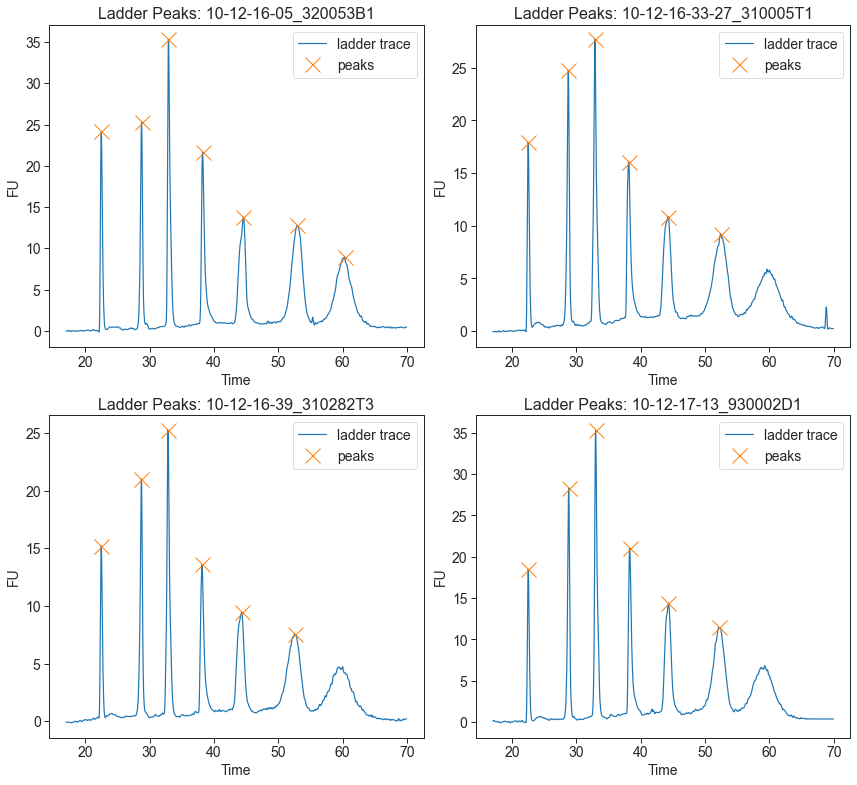

In [25]:
from scipy.signal import find_peaks

filenames = ['10-12-16-05_320053B1', \
            '10-12-16-33-27_310005T1',\
            '10-12-16-39_310282T3',\
            '10-12-17-13_930002D1']

nrows=2
ncolumns=2
figure(figsize=(ncolumns*6, nrows*4+3))

ladder_dict = {}
ladder_times = {}
ladder_values = {}
for i, file in enumerate(filenames):
    
    ladder_df = pd.read_csv(file+'_ladder.csv')
    ladder_time = np.array(ladder_df['Time'])
    ladder_value = np.array(ladder_df['Value'])
    ladder_times[file] = ladder_time
    ladder_values[file] = ladder_value
    
    peaks,_ = find_peaks(ladder_value, height=7.5, distance=15)
    ladder_dict[file] = list(peaks[:6])
    
    subplot(nrows,ncolumns,i+1)
    plot(ladder_time, ladder_value, label='ladder trace')
    plot(ladder_time[peaks], ladder_value[peaks], 'x', label='peaks', markersize=15)
    legend(fontsize=14)
    xlabel('Time', fontsize=14)
    ylabel('FU', fontsize=14)
    xticks(fontsize=14)
    yticks(fontsize=14)
    title('Ladder Peaks: '+file, fontsize=16)
    tight_layout()

<Figure size 864x792 with 0 Axes>

Text(0, 0.5, 'Calculated nts (from time)')

Text(0.5, 0, 'Ladder nts')

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.,
        4000., 4500.]),
 <a list of 11 Text major ticklabel objects>)

(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.]),
 <a list of 7 Text major ticklabel objects>)

Text(0.5, 1.0, 'Ladder polynomial fit: 10-12-16-05_320053B1')

Text(0, 0.5, 'Calculated nts (from time)')

Text(0.5, 0, 'Ladder nts')

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.,
        4000., 4500.]),
 <a list of 11 Text major ticklabel objects>)

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.,
        4000., 4500.]),
 <a list of 11 Text major ticklabel objects>)

Text(0.5, 1.0, 'Ladder polynomial fit: 10-12-16-33-27_310005T1')

Text(0, 0.5, 'Calculated nts (from time)')

Text(0.5, 0, 'Ladder nts')

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.,
        4000., 4500.]),
 <a list of 11 Text major ticklabel objects>)

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.,
        4000., 4500.]),
 <a list of 11 Text major ticklabel objects>)

Text(0.5, 1.0, 'Ladder polynomial fit: 10-12-16-39_310282T3')

Text(0, 0.5, 'Calculated nts (from time)')

Text(0.5, 0, 'Ladder nts')

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.,
        4000., 4500.]),
 <a list of 11 Text major ticklabel objects>)

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.,
        4000., 4500.]),
 <a list of 11 Text major ticklabel objects>)

Text(0.5, 1.0, 'Ladder polynomial fit: 10-12-17-13_930002D1')

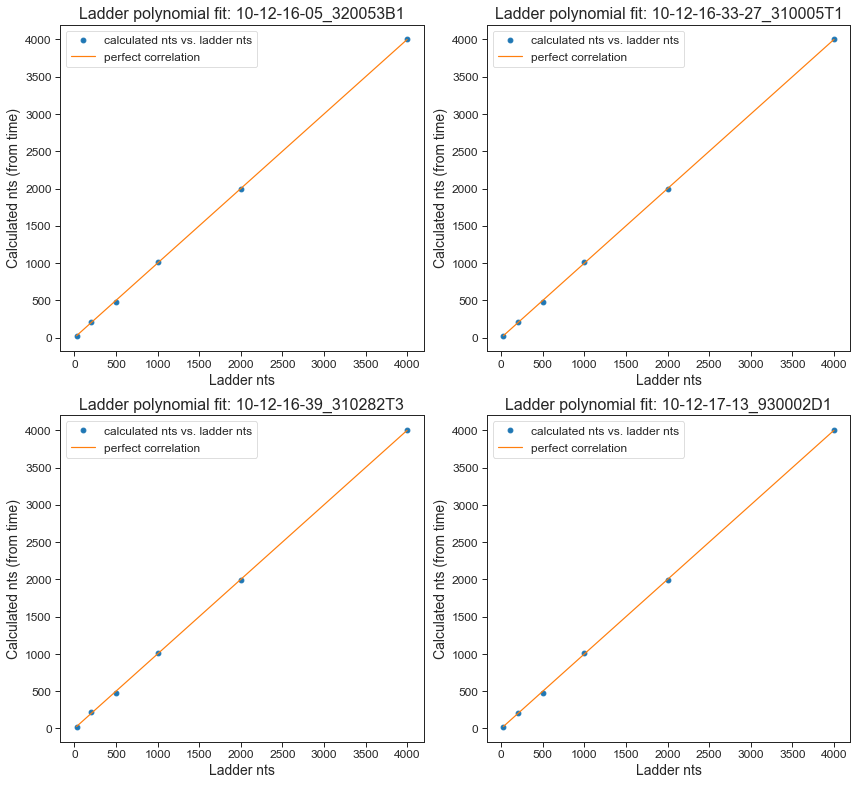

In [57]:
nrows=2
ncolumns=2
figure(figsize=(ncolumns*6, nrows*4+3))

ladder_nts = {}
for i,sample in enumerate(ladder_dict):
    peak_times = ladder_times[sample][ladder_dict[sample]]
    peak_fu = np.array([25, 200, 500, 1000, 2000, 4000])

#     len(peak_times[:6])
#     len(peak_fu)

    ladder_fit = np.polyfit(x=peak_times, y = peak_fu, deg = 4)
    lf = np.poly1d(ladder_fit)
    ladder_nts[sample] = lf
    
    subplot(nrows,ncolumns,i+1)
    plot(peak_fu, lf(peak_times), 'o',label='calculated nts vs. ladder nts')
    plot(peak_fu, peak_fu,label='perfect correlation')
    ylabel('Calculated nts (from time)', fontsize=14)
    xlabel('Ladder nts', fontsize=14)
    yticks(fontsize=12)
    xticks(fontsize=12)
    title('Ladder polynomial fit: '+sample, fontsize=16)
    legend(fontsize=12)
    tight_layout()

### finding peaks in my data now

<Figure size 864x792 with 0 Axes>

Text(0, 0.5, 'Flourescence Units')

Text(0.5, 0, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-05_320053B1')

Text(82.45, 0.5, 'Flourescence Units')

Text(0.5, 402.86, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-05_320053B1')

Text(24.367999999999995, 0.5, 'Flourescence Units')

Text(0.5, 388.03399999999993, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-05_320053B1')

Text(24.36800000000001, 0.5, 'Flourescence Units')

Text(0.5, 388.034, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-05_320053B1')

Text(24.36800000000001, 0.5, 'Flourescence Units')

Text(0.5, 388.03399999999993, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-05_320053B1')

Text(24.36800000000001, 0.5, 'Flourescence Units')

Text(0.5, 388.034, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-05_320053B1')

Text(24.36800000000001, 0.5, 'Flourescence Units')

Text(0.5, 388.03399999999993, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-05_320053B1')

Text(24.36800000000001, 0.5, 'Flourescence Units')

Text(0.5, 388.034, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-05_320053B1')

Text(24.36800000000001, 0.5, 'Flourescence Units')

Text(0.5, 388.03399999999993, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-05_320053B1')

Text(24.36800000000001, 0.5, 'Flourescence Units')

Text(0.5, 388.034, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-05_320053B1')

Text(0, 0.5, 'Flourescence Units')

Text(0.5, 0, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-33-27_310005T1')

Text(421.409, 0.5, 'Flourescence Units')

Text(0.5, 388.034, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-33-27_310005T1')

Text(446.18399999999997, 0.5, 'Flourescence Units')

Text(0.5, 388.03399999999993, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-33-27_310005T1')

Text(446.18399999999997, 0.5, 'Flourescence Units')

Text(0.5, 388.034, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-33-27_310005T1')

Text(446.18399999999997, 0.5, 'Flourescence Units')

Text(0.5, 388.03399999999993, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-33-27_310005T1')

Text(446.18399999999997, 0.5, 'Flourescence Units')

Text(0.5, 388.034, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-33-27_310005T1')

Text(446.18399999999997, 0.5, 'Flourescence Units')

Text(0.5, 388.03399999999993, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-33-27_310005T1')

Text(446.18399999999997, 0.5, 'Flourescence Units')

Text(0.5, 388.034, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-33-27_310005T1')

Text(446.18399999999997, 0.5, 'Flourescence Units')

Text(0.5, 388.03399999999993, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-33-27_310005T1')

Text(446.18399999999997, 0.5, 'Flourescence Units')

Text(0.5, 388.034, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-33-27_310005T1')

Text(0, 0.5, 'Flourescence Units')

Text(0.5, 0, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-39_310282T3')

Text(24.36800000000001, 0.5, 'Flourescence Units')

Text(0.5, -11.93200000000004, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-39_310282T3')

Text(24.36800000000001, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-39_310282T3')

Text(24.36800000000001, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-39_310282T3')

Text(24.36800000000001, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-39_310282T3')

Text(14.36800000000001, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-39_310282T3')

Text(24.368000000000023, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-39_310282T3')

Text(24.367999999999995, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-39_310282T3')

Text(24.36800000000001, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-39_310282T3')

Text(24.36800000000001, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-39_310282T3')

Text(0, 0.5, 'Flourescence Units')

Text(0.5, 0, 'Nucleotides')

Text(0.5, 1.0, '10-12-17-13_930002D1')

Text(461.1839999999999, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-17-13_930002D1')

Text(461.1839999999999, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-17-13_930002D1')

Text(461.1839999999999, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-17-13_930002D1')

Text(461.1839999999999, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-17-13_930002D1')

Text(461.1839999999999, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-17-13_930002D1')

Text(461.1839999999999, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-17-13_930002D1')

Text(461.1839999999999, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-17-13_930002D1')

Text(461.1839999999999, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-17-13_930002D1')

Text(461.1839999999999, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-17-13_930002D1')

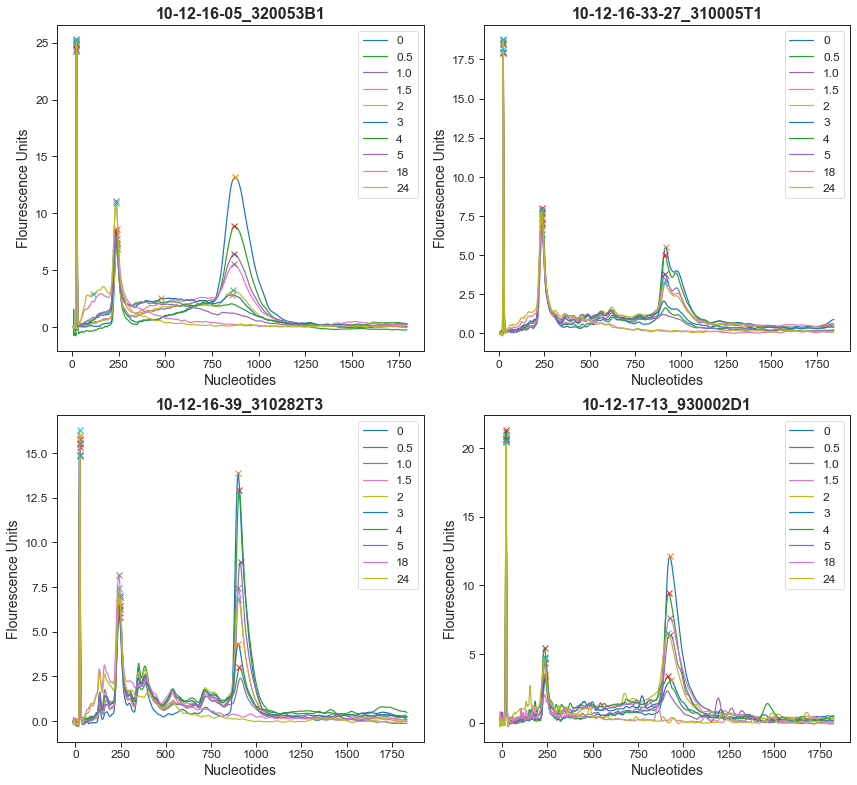

In [62]:
from scipy.signal import find_peaks

nrows=2
ncolumns=2
figure(figsize=(ncolumns*6, nrows*4+3))

# filenames = ['10-12-16-05_320053B1', \
#             '10-12-16-33-27_310005T1',\
#             '10-12-16-39_310282T3',\
#             '10-12-17-13_930002D1']

samples_dict = {}
for file in filenames:
    sample_df = pd.read_csv(file+'_samples.csv')
    samples_dict[file] = sample_df

for i, sample in enumerate(ladder_nts):
    
    nt_array = ladder_nts[sample](ladder_times[sample])
#     nt_array
    
#     peaks_store = []
#     heights_store = []
    
    subplot(nrows,ncolumns,i+1)
    
    #read in dataframe for per sample here
    sample_df = samples_dict[sample]
    
    timepoints = [0,0.5,1.0,1.5,2,3,4,5,18,24]
    
    for i,time in enumerate(timepoints):
        data = np.array(sample_df[sample_df['Timepoint']==time]['Value'])
        
        peaks, _ = find_peaks(data, distance=50, height=2.5)
#         peaks_store.append(peaks)
#         heights_store.append(data[peaks])

        plot(nt_array[:int(len(nt_array)/2)],data[:int(len(nt_array)/2)], label=time)
        plot(np.array(nt_array)[peaks], data[peaks], 'x',markersize=6)
        ylabel('Flourescence Units', fontsize=14)
        xlabel('Nucleotides', fontsize=14)
        legend()
        title(sample, fontweight='bold')
        tight_layout()

## applying background subtraction 

In [87]:
normalized_samples = {}
for sample in samples_dict:
    
    sample_df = samples_dict[sample]

    normalized_trace = []
    nts_list = []
    for time in timepoints:
        trace = np.array(sample_df[sample_df['Timepoint']==time]['Value'])
        clean_trace, _ = baseline_xi(trace)
        normalized_trace.append(clean_trace)
        
        #sneaking in nucleotide conversions while we're at it
        times = sample_df[sample_df['Timepoint']==time]['Time']
        nts = ladder_nts[sample](times)
        nts_list.append(nts)
    
    sample_df['Normalized_Value'] = np.array(normalized_trace).flatten()
    sample_df['Nucleotides'] = np.array(nts_list).flatten()
    sample_df
    normalized_samples[sample] = sample_df


,Time,Value,Timepoint,Normalized_Value,Nucleotides
0,17.00,-0.198538,0.0,0.008076,25.657409
1,17.05,-0.205864,0.0,-0.002273,25.025598
2,17.10,-0.212813,0.0,-0.012246,24.404182
3,17.15,-0.208647,0.0,-0.011104,23.793182
4,17.20,-0.192557,0.0,0.001963,23.192620
...,...,...,...,...,...
10595,69.75,-0.005780,24.0,-0.006136,11410.679672
10596,69.80,0.006990,24.0,0.007168,11440.977954
10597,69.85,0.014900,24.0,0.015611,11471.332459
10598,69.90,0.018023,24.0,0.019266,11501.743255


,Time,Value,Timepoint,Normalized_Value,Nucleotides
0,17.00,0.061500,0.0,0.065310,23.819222
1,17.05,0.061500,0.0,0.065845,23.242220
2,17.10,0.061500,0.0,0.066379,22.674658
3,17.15,0.061500,0.0,0.066910,22.116563
4,17.20,0.046600,0.0,0.052538,21.567966
...,...,...,...,...,...
10595,69.75,0.058000,24.0,-0.009097,11923.709215
10596,69.80,0.069195,24.0,0.002658,11955.388197
10597,69.85,0.068100,24.0,0.002122,11987.125048
10598,69.90,0.072900,24.0,0.007480,12018.919831


,Time,Value,Timepoint,Normalized_Value,Nucleotides
0,17.00,-0.052300,0.0,0.027481,-11.053662
1,17.05,-0.055800,0.0,0.024091,-11.084726
2,17.10,-0.072400,0.0,0.007600,-11.111548
3,17.15,-0.078000,0.0,0.002109,-11.134071
4,17.20,-0.087000,0.0,-0.006784,-11.152237
...,...,...,...,...,...
10595,69.75,-0.101551,24.0,-0.004153,11246.824802
10596,69.80,-0.101551,24.0,-0.003693,11274.495752
10597,69.85,-0.101551,24.0,-0.003231,11302.206589
10598,69.90,-0.101551,24.0,-0.002770,11329.957322


,Time,Value,Timepoint,Normalized_Value,Nucleotides
0,17.00,0.000880,0.0,-0.015576,-7.395342
1,17.05,0.017229,0.0,0.002194,-7.497469
2,17.10,0.038361,0.0,0.024747,-7.594111
3,17.15,0.035605,0.0,0.023413,-7.685227
4,17.20,0.025300,0.0,0.014533,-7.770778
...,...,...,...,...,...
10595,69.75,0.195107,24.0,0.107613,12914.524737
10596,69.80,0.195107,24.0,0.107276,12950.629112
10597,69.85,0.195107,24.0,0.106938,12986.804234
10598,69.90,0.195107,24.0,0.106601,13023.050185


<Figure size 864x792 with 0 Axes>

Text(0, 0.5, 'Flourescence Units')

Text(0.5, 0, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-05_320053B1')

Text(82.45, 0.5, 'Flourescence Units')

Text(0.5, 402.86, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-05_320053B1')

Text(24.367999999999995, 0.5, 'Flourescence Units')

Text(0.5, 388.03399999999993, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-05_320053B1')

Text(24.36800000000001, 0.5, 'Flourescence Units')

Text(0.5, 388.034, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-05_320053B1')

Text(24.36800000000001, 0.5, 'Flourescence Units')

Text(0.5, 388.03399999999993, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-05_320053B1')

Text(24.36800000000001, 0.5, 'Flourescence Units')

Text(0.5, 388.034, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-05_320053B1')

Text(24.36800000000001, 0.5, 'Flourescence Units')

Text(0.5, 388.03399999999993, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-05_320053B1')

Text(24.36800000000001, 0.5, 'Flourescence Units')

Text(0.5, 388.034, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-05_320053B1')

Text(24.36800000000001, 0.5, 'Flourescence Units')

Text(0.5, 388.03399999999993, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-05_320053B1')

Text(24.36800000000001, 0.5, 'Flourescence Units')

Text(0.5, 388.034, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-05_320053B1')

Text(0, 0.5, 'Flourescence Units')

Text(0.5, 0, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-33-27_310005T1')

Text(421.409, 0.5, 'Flourescence Units')

Text(0.5, 388.034, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-33-27_310005T1')

Text(446.18399999999997, 0.5, 'Flourescence Units')

Text(0.5, 388.03399999999993, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-33-27_310005T1')

Text(446.18399999999997, 0.5, 'Flourescence Units')

Text(0.5, 388.034, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-33-27_310005T1')

Text(446.18399999999997, 0.5, 'Flourescence Units')

Text(0.5, 388.03399999999993, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-33-27_310005T1')

Text(446.18399999999997, 0.5, 'Flourescence Units')

Text(0.5, 388.034, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-33-27_310005T1')

Text(446.18399999999997, 0.5, 'Flourescence Units')

Text(0.5, 388.03399999999993, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-33-27_310005T1')

Text(446.18399999999997, 0.5, 'Flourescence Units')

Text(0.5, 388.034, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-33-27_310005T1')

Text(446.18399999999997, 0.5, 'Flourescence Units')

Text(0.5, 388.03399999999993, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-33-27_310005T1')

Text(446.18399999999997, 0.5, 'Flourescence Units')

Text(0.5, 388.034, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-33-27_310005T1')

Text(0, 0.5, 'Flourescence Units')

Text(0.5, 0, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-39_310282T3')

Text(24.36800000000001, 0.5, 'Flourescence Units')

Text(0.5, -11.93200000000004, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-39_310282T3')

Text(24.36800000000001, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-39_310282T3')

Text(24.36800000000001, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-39_310282T3')

Text(24.36800000000001, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-39_310282T3')

Text(14.36800000000001, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-39_310282T3')

Text(24.368000000000023, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-39_310282T3')

Text(24.367999999999995, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-39_310282T3')

Text(24.36800000000001, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-39_310282T3')

Text(24.36800000000001, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-16-39_310282T3')

Text(0, 0.5, 'Flourescence Units')

Text(0.5, 0, 'Nucleotides')

Text(0.5, 1.0, '10-12-17-13_930002D1')

Text(461.1839999999999, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-17-13_930002D1')

Text(461.1839999999999, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-17-13_930002D1')

Text(461.1839999999999, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-17-13_930002D1')

Text(461.1839999999999, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-17-13_930002D1')

Text(461.1839999999999, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-17-13_930002D1')

Text(461.1839999999999, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-17-13_930002D1')

Text(461.1839999999999, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-17-13_930002D1')

Text(461.1839999999999, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-17-13_930002D1')

Text(461.1839999999999, 0.5, 'Flourescence Units')

Text(0.5, 24.36800000000001, 'Nucleotides')

Text(0.5, 1.0, '10-12-17-13_930002D1')

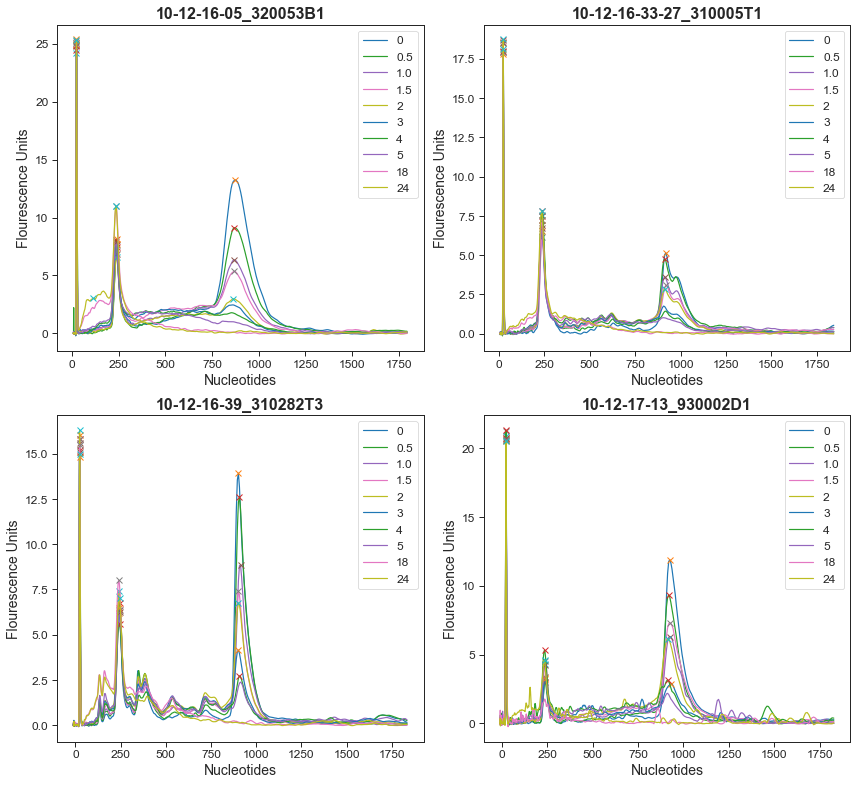

In [84]:
from scipy.signal import find_peaks

nrows=2
ncolumns=2
figure(figsize=(ncolumns*6, nrows*4+3))

for i, sample in enumerate(ladder_nts):
    
    nt_array = ladder_nts[sample](ladder_times[sample])
#     nt_array
    
#     peaks_store = []
#     heights_store = []
    
    subplot(nrows,ncolumns,i+1)
    
    #read in dataframe for per sample here
    sample_df = samples_dict[sample]
    
    timepoints = [0,0.5,1.0,1.5,2,3,4,5,18,24]
    
    for i,time in enumerate(timepoints):
        data = np.array(sample_df[sample_df['Timepoint']==time]['Normalized_Value'])
        
        peaks, _ = find_peaks(data, distance=50, height=2.5)
#         peaks_store.append(peaks)
#         heights_store.append(data[peaks])

        plot(nt_array[:int(len(nt_array)/2)],data[:int(len(nt_array)/2)], label=time)
        plot(np.array(nt_array)[peaks], data[peaks], 'x',markersize=6)
        ylabel('Flourescence Units', fontsize=14)
        xlabel('Nucleotides', fontsize=14)
        legend()
        title(sample, fontweight='bold')
        tight_layout()

## now moving onto calculating relative areas

<Figure size 864x792 with 0 Axes>

[749, 997]
[749, 997]
[749, 997]
[749, 997]
[749, 997]
[749, 997]
[749, 997]
[749, 997]
[749, 997]
[749, 997]


Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text major ticklabel objects>)

(array([-5.,  0.,  5., 10., 15., 20., 25., 30.]),
 <a list of 8 Text major ticklabel objects>)

Text(0.5, 1.0, 'Fraction Intact vs. Time: 10-12-16-05_320053B1')

[848, 997]
[848, 997]
[848, 997]
[848, 997]
[848, 997]
[848, 997]
[848, 997]
[848, 997]
[848, 997]
[848, 997]


Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text major ticklabel objects>)

(array([-5.,  0.,  5., 10., 15., 20., 25., 30.]),
 <a list of 8 Text major ticklabel objects>)

Text(0.5, 1.0, 'Fraction Intact vs. Time: 10-12-16-33-27_310005T1')

[849, 998]
[849, 998]
[849, 998]
[849, 998]
[849, 998]
[849, 998]
[849, 998]
[849, 998]
[849, 998]
[849, 998]


Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text major ticklabel objects>)

(array([-5.,  0.,  5., 10., 15., 20., 25., 30.]),
 <a list of 8 Text major ticklabel objects>)

Text(0.5, 1.0, 'Fraction Intact vs. Time: 10-12-16-39_310282T3')

[849, 999]
[849, 999]
[849, 999]
[849, 999]
[849, 999]
[849, 999]
[849, 999]
[849, 999]
[849, 999]
[849, 999]


Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text major ticklabel objects>)

(array([-5.,  0.,  5., 10., 15., 20., 25., 30.]),
 <a list of 8 Text major ticklabel objects>)

Text(0.5, 1.0, 'Fraction Intact vs. Time: 10-12-17-13_930002D1')

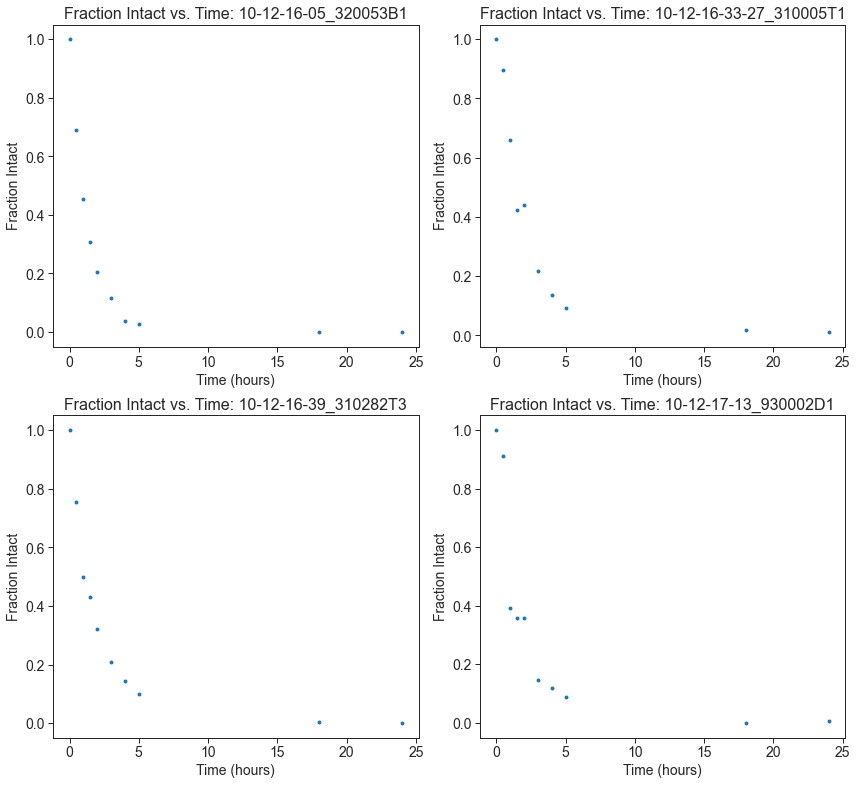

In [172]:
nrows=2
ncolumns=2
figure(figsize=(ncolumns*6, nrows*4+3))

start_nt = 850
end_nt = 1000

p4p6_start = 200
p4p6_end = 300

areas_dict = {}

for i,sample in enumerate(samples_dict):
    samples_df = samples_dict[sample]
    
    if sample == '10-12-16-05_320053B1':
        start_nt = 750
        end_nt = 1000
    else:
        start_nt = 850
        end_nt = 1000
        
    
    #grabbing nucleotides
    select_data = samples_df[samples_df['Timepoint']==0.0]
    nts = np.array([int(x) for x in select_data['Nucleotides']])
    
    #indices for P4P6
    p4p6_start_idx = min(range(len(nts)), key=lambda i: abs(nts[i]-p4p6_start))
    p4p6_end_idx = min(range(len(nts)), key=lambda i: abs(nts[i]-p4p6_end))

    #indices for mRNA
    first_idx = min(range(len(nts)), key=lambda i: abs(nts[i]-start_nt))
    last_idx = min(range(len(nts)), key=lambda i: abs(nts[i]-end_nt))    

#     print(sample)
    timepoints_dict = {}
    for time in timepoints:
    
        select_data = samples_df[samples_df['Timepoint']==time]
        nts = np.array([int(x) for x in select_data['Nucleotides']])

        vals = np.array(select_data['Normalized_Value'])

        p4p6_area = np.trapz(y=vals[p4p6_start_idx:p4p6_end_idx], x=nts[p4p6_start_idx:p4p6_end_idx])
#         print(time)
#         print([vals[first_idx], vals[last_idx]])
        print([nts[first_idx],nts[last_idx]])
        background_area = np.trapz(y=[vals[first_idx], vals[last_idx]], x=[nts[first_idx],nts[last_idx]])
        total_area = np.trapz(y=vals[first_idx:last_idx], x=nts[first_idx:last_idx])

        sample_dict = {}
        sample_dict['Timepoints'] = time
        sample_dict['P4P6_area'] = p4p6_area
        sample_dict['Background'] = background_area
        sample_dict['Total_Area'] = total_area

        timepoints_dict[time] = sample_dict

    areas_df = pd.DataFrame.from_dict(timepoints_dict, orient='index')
    areas_df['Subtracted'] = areas_df['Total_Area']-areas_df['Background']
    areas_df['Normalized'] = areas_df['Subtracted']/areas_df['P4P6_area']

    initial_time = 0.0
#     if sample == '10-12-16-33-27_310005T1':
#         initial_time = 0.5

    initial_val = float(areas_df[areas_df['Timepoints']==initial_time]['Normalized'])

    areas_df['FractionIntact'] = (areas_df['Normalized']/initial_val).clip(0)

    areas_dict[sample] = areas_df
    
    subplot(nrows,ncolumns,i+1)
    sns.scatterplot(data=areas_df, x='Timepoints', y='FractionIntact')
    xlabel('Time (hours)', fontsize=14)
    ylabel('Fraction Intact', fontsize=14)
    yticks(fontsize=14)
    xticks(fontsize=14)
    title('Fraction Intact vs. Time: '+sample, fontsize=16)
    tight_layout()

In [170]:
for sample in areas_dict:
    print(sample)
    areas_dict[sample]

10-12-16-05_320053B1


,Timepoints,P4P6_area,Background,Total_Area,Subtracted,Normalized,FractionIntact
0.0,0.0,309.266984,822.580601,2021.734726,1199.154125,3.877408,1.000000
0.5,0.5,285.989154,666.741175,1432.072937,765.331762,2.676087,0.690174
1.0,1.0,280.966124,528.610502,1024.796407,496.185905,1.765999,0.455459
1.5,1.5,320.479513,499.510264,882.256790,382.746526,1.194293,0.308013
2.0,2.0,261.572140,302.740586,510.347380,207.606794,0.793688,0.204696
3.0,3.0,341.959862,287.266184,439.374863,152.108679,0.444814,0.114720
4.0,4.0,352.210917,294.827353,346.650470,51.823117,0.147137,0.037947
5.0,5.0,354.543385,162.688850,200.726828,38.037978,0.107287,0.027670
18.0,18.0,512.100626,26.486247,23.116150,-3.370098,-0.006581,0.000000
24.0,24.0,508.475537,34.229544,30.629719,-3.599826,-0.007080,0.000000


10-12-16-33-27_310005T1


,Timepoints,P4P6_area,Background,Total_Area,Subtracted,Normalized,FractionIntact
0.0,0.0,263.798760,272.617319,427.905173,155.287854,0.588660,1.113913
0.5,0.5,303.651634,283.116508,443.584730,160.468222,0.528462,1.000000
1.0,1.0,284.107039,240.025951,350.174342,110.148391,0.387700,0.733640
1.5,1.5,257.872236,230.122005,294.441212,64.319207,0.249423,0.471979
2.0,2.0,308.368005,205.286559,285.188334,79.901775,0.259112,0.490313
3.0,3.0,287.315934,147.333505,184.226391,36.892886,0.128405,0.242979
4.0,4.0,317.720090,127.445687,152.988431,25.542745,0.080394,0.152128
5.0,5.0,276.323877,108.500131,123.318102,14.817971,0.053625,0.101475
18.0,18.0,313.853329,6.136456,9.239076,3.102620,0.009886,0.018706
24.0,24.0,348.261253,10.082071,12.405036,2.322965,0.006670,0.012622


10-12-16-39_310282T3


,Timepoints,P4P6_area,Background,Total_Area,Subtracted,Normalized,FractionIntact
0.0,0.0,247.002794,174.520177,930.651881,756.131704,3.061227,1.000000
0.5,0.5,279.622474,205.901132,853.338472,647.437340,2.315398,0.756363
1.0,1.0,268.182625,206.058714,615.965866,409.907151,1.528463,0.499297
1.5,1.5,265.079952,167.756520,516.303681,348.547161,1.314876,0.429526
2.0,2.0,320.007715,185.562545,501.514827,315.952282,0.987327,0.322527
3.0,3.0,283.777126,133.936558,314.888616,180.952058,0.637656,0.208301
4.0,4.0,246.595935,117.091211,225.587432,108.496221,0.439976,0.143725
5.0,5.0,280.317663,118.025360,203.148236,85.122875,0.303666,0.099197
18.0,18.0,382.298005,19.141584,25.734803,6.593219,0.017246,0.005634
24.0,24.0,334.012928,14.472072,16.129643,1.657570,0.004963,0.001621


10-12-17-13_930002D1


,Timepoints,P4P6_area,Background,Total_Area,Subtracted,Normalized,FractionIntact
0.0,0.0,106.608562,373.045121,941.250613,568.205491,5.329830,1.000000
0.5,0.5,99.666828,309.597956,793.057409,483.459453,4.850756,0.910115
1.0,1.0,131.070338,297.348467,571.488389,274.139921,2.091548,0.392423
1.5,1.5,167.385737,361.174001,681.863471,320.689471,1.915871,0.359462
2.0,2.0,156.714237,289.483032,589.006607,299.523575,1.911272,0.358599
3.0,3.0,133.924518,183.602564,288.620667,105.018103,0.784159,0.147126
4.0,4.0,225.445688,172.858559,316.566047,143.707488,0.637437,0.119598
5.0,5.0,172.050356,125.741604,206.631818,80.890214,0.470154,0.088212
18.0,18.0,86.087818,51.044465,34.861011,-16.183454,-0.187988,0.000000
24.0,24.0,206.745923,10.046141,18.033329,7.987187,0.038633,0.007248


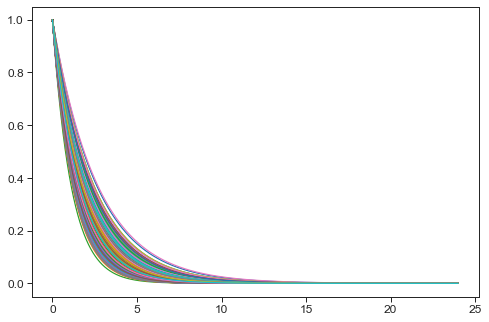

In [175]:
#repeat 1,000 per sample
areas_df = areas_dict['10-12-17-13_930002D1']
b_coeff = []
for i in np.arange(0,1000,1):
    frac_intact = np.array(areas_df['FractionIntact'])

    #avoiding negative values from background subtraction
    frac_intact = np.clip(a=frac_intact, a_min=0, a_max=max(frac_intact))

    #generate bootstrap indices
    bs_indices = bootstrap_inds(frac_intact)

    fit_t = [timepoints[i] for i in bs_indices]
    fit_fracint = [frac_intact[i] for i in bs_indices] 

    popt, pcov = curve_fit(func, fit_t, fit_fracint)
#         Switching from A*e^(-bt) to just e^(-bt)
#         a_coeff.append(popt[0])
    b_coeff.append(popt[0])

    x=np.arange(0,24,0.005)
    y=[np.exp(-1*popt[0]*x1) for x1 in x]

    plot(x,y)

<Figure size 864x792 with 0 Axes>

Text(0.5, 1.0, 'Bootstrapped exponential fits (n=1000) \n10-12-16-05_320053B1')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

Text(0.5, 1.0, 'Bootstrapped exponential fits (n=1000) \n10-12-16-33-27_310005T1')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

Text(0.5, 1.0, 'Bootstrapped exponential fits (n=1000) \n10-12-16-39_310282T3')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

Text(0.5, 1.0, 'Bootstrapped exponential fits (n=1000) \n10-12-17-13_930002D1')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

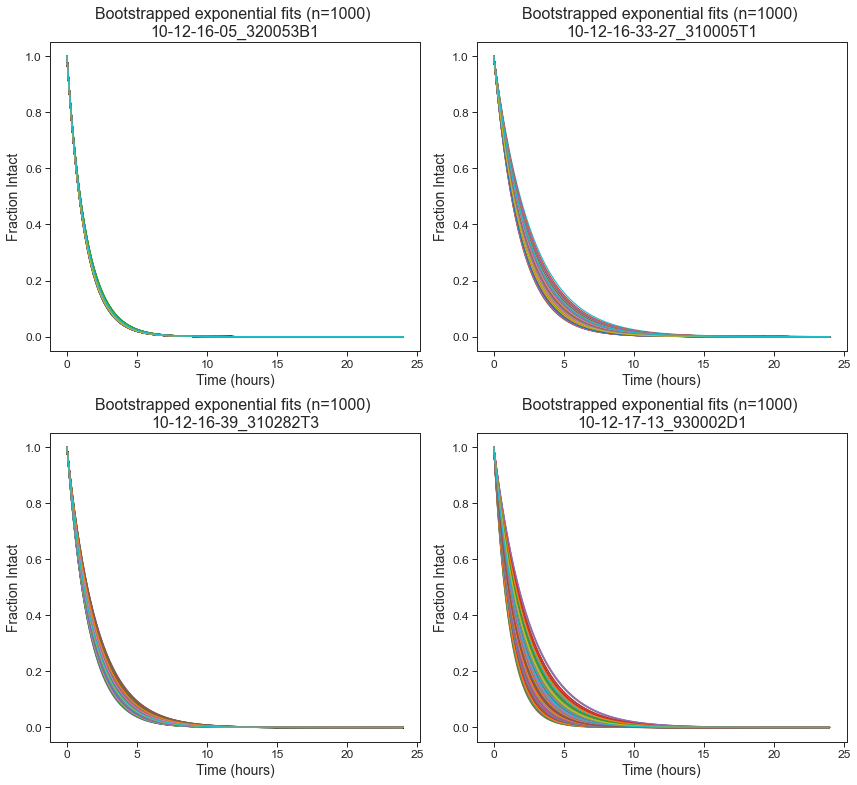

In [181]:
from scipy.optimize import curve_fit

#returns indices, bootstrapped
def bootstrap_inds(x):
    bs_indices = np.random.choice(range(len(x)),len(x))
    return bs_indices

#function for exponential fitting
def func(x, b):
    return np.exp(-b*x)


nrows=2
ncolumns=2
figure(figsize=(ncolumns*6, nrows*4+3))


expfits_dict = {}
for j,sample in enumerate(areas_dict):
    # a_coeff = [] 
    b_coeff = []
    
    areas_df = areas_dict[sample]

    subplot(nrows,ncolumns,j+1)
    #repeat 1,000 per sample
    for i in np.arange(0,1000,1):
        frac_intact = np.array(areas_df['FractionIntact'])

        #avoiding negative values from background subtraction
        frac_intact = np.clip(a=frac_intact, a_min=0, a_max=max(frac_intact))

        #generate bootstrap indices
        bs_indices = bootstrap_inds(frac_intact)

        fit_t = [timepoints[i] for i in bs_indices]
        fit_fracint = [frac_intact[i] for i in bs_indices] 

        popt, pcov = curve_fit(func, fit_t, fit_fracint)
    #         Switching from A*e^(-bt) to just e^(-bt)
    #         a_coeff.append(popt[0])
        b_coeff.append(popt[0])

        x=np.arange(0,24,0.005)
        y=[np.exp(-1*popt[0]*x1) for x1 in x]
        plot(x,y)

    title('Bootstrapped exponential fits (n=1000) \n'+sample)
    xlabel('Time (hours)')
    ylabel('Fraction Intact')
    tight_layout()
    
    expfits_dict[sample] = b_coeff
    
savefig('bootstrapped_fits.png', dpi=300)

<Figure size 864x792 with 0 Axes>

Text(0.5, 1.0, '10-12-16-05_320053B1: Exponential Fit \n (Bootstrapped, Background Subtracted)')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

Text(10, 0.6, 'Frac_Intact = exp(-0.772t)')

Text(10, 0.4, 'Time Constant: 1.295 hrs')

(array([-5.,  0.,  5., 10., 15., 20., 25., 30.]),
 <a list of 8 Text major ticklabel objects>)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text major ticklabel objects>)

Text(0.5, 1.0, '10-12-16-33-27_310005T1: Exponential Fit \n (Bootstrapped, Background Subtracted)')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

Text(10, 0.6, 'Frac_Intact = exp(-0.464t)')

Text(10, 0.4, 'Time Constant: 2.154 hrs')

(array([-5.,  0.,  5., 10., 15., 20., 25., 30.]),
 <a list of 8 Text major ticklabel objects>)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text major ticklabel objects>)

Text(0.5, 1.0, '10-12-16-39_310282T3: Exponential Fit \n (Bootstrapped, Background Subtracted)')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

Text(10, 0.6, 'Frac_Intact = exp(-0.561t)')

Text(10, 0.4, 'Time Constant: 1.782 hrs')

(array([-5.,  0.,  5., 10., 15., 20., 25., 30.]),
 <a list of 8 Text major ticklabel objects>)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text major ticklabel objects>)

Text(0.5, 1.0, '10-12-17-13_930002D1: Exponential Fit \n (Bootstrapped, Background Subtracted)')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

Text(10, 0.6, 'Frac_Intact = exp(-0.607t)')

Text(10, 0.4, 'Time Constant: 1.646 hrs')

(array([-5.,  0.,  5., 10., 15., 20., 25., 30.]),
 <a list of 8 Text major ticklabel objects>)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text major ticklabel objects>)

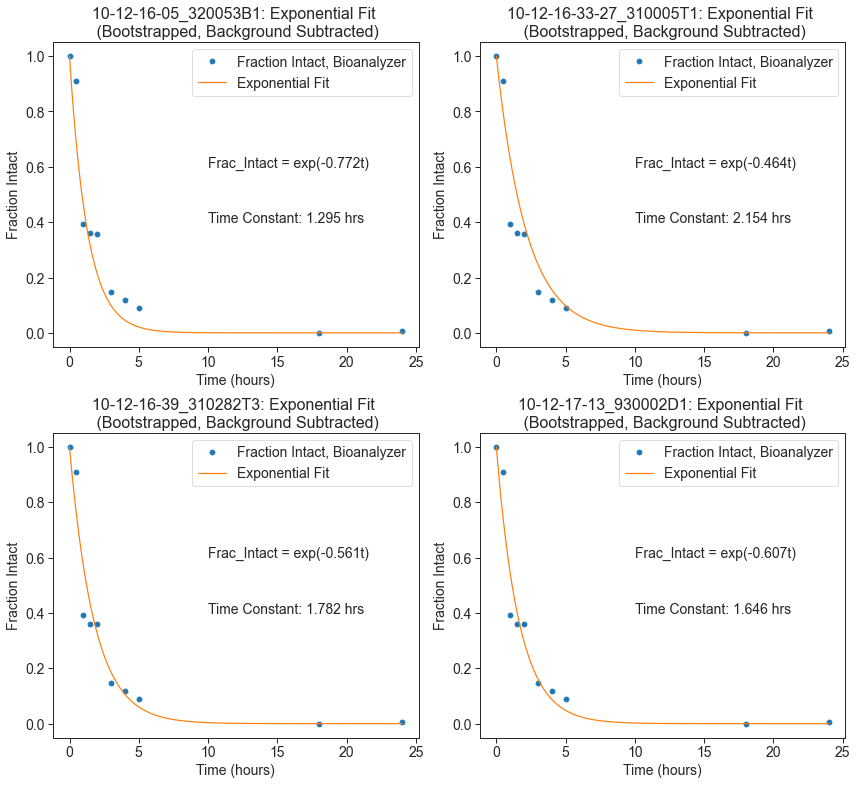

In [182]:
nrows=2
ncolumns=2
figure(figsize=(ncolumns*6, nrows*4+3))

export_dict = {}
for i, sample in enumerate(expfits_dict):
    b_coeff = expfits_dict[sample]
    
    bootstrapped_fits=np.mean(b_coeff)
    bootstrapped_err =np.std(b_coeff)
    
    append_dict = {}
    append_dict['Sample'] = sample
    append_dict['kdeg'] = bootstrapped_fits
    append_dict['kdeg_err'] = bootstrapped_err
    
    export_dict[sample] = append_dict
    
    subplot(nrows,ncolumns,i+1)
    
    x=np.arange(0,24,0.005)
    y=[np.exp(-1*bootstrapped_fits*x1) for x1 in x]
    plot(timepoints, areas_df['FractionIntact'], 'o', label='Fraction Intact, Bioanalyzer')
    plot(x,y, label='Exponential Fit')
    title(sample+': Exponential Fit \n (Bootstrapped, Background Subtracted)', fontsize=16)
    xlabel('Time (hours)', fontsize=14)
    ylabel('Fraction Intact', fontsize=14)
    text(x=10, y=0.6,s="Frac_Intact = exp(-{:.3f}t)".format(bootstrapped_fits), fontsize=14)
    text(x=10, y=0.4,s="Time Constant: {:.3f} hrs".format(1/bootstrapped_fits), fontsize=14)
    xticks(fontsize=14)
    yticks(fontsize=14)
    legend(fontsize=14)
    tight_layout()

savefig('ExpFit_BioAnalyzer_BackgroundSubtracted.png', dpi=300)



In [186]:
export_df = pd.DataFrame.from_dict(export_dict, orient='index')
export_df.to_csv('Bioanalyzer_fits.csv')